## **Introduction 项目介绍**
As a wine enthusiast, I am curious to find out what attributes ultimately make a good wine. Here I am using data from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) to try to predict wine quality based on its score ranging from 0-10. The attributes in the dataset include:
*   fixed acidity 固定酸度
*   volatile acidity 波动酸度
*   citric acid 柠檬酸
*   residual sugar 残糖
*   chlorides 氯化物
*  free sulfur dioxide 自由的二氧化硫？
*  total sulfur dioxide 总二氧化硫
*  density 浓度
*  pH 酸碱度
*  sulphates 硫酸盐
*  	alcohol 酒精浓度

作为一个葡萄酒爱好者，我想透过这个来自于UCI的数据集，了解哪些因素是会影响一瓶酒的质量评分的。

Methods that I used in this project were: （会用到的模块有以下3个）
*   Exploratory Data Analysis (EDA) 探索性数据分析
*   Decision Tree 决策树
*   Random Forest 随机森林

In [9]:
## Exploratory Data Analysis 探索性数据分析
##### Import libraries 录入模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from scipy import stats
%matplotlib inline

In [4]:
#### Read the data 录入数据
wine = pd.read_csv(r'/content/winequality-red.csv')

In [5]:
#### Understand the data 观察数据表
print(wine.shape)
wine.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
#### descriptive statistics 描述统计学
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


What caught my eye was the potential outliers from the column 'residual sugar'. The descriptive statistics showed that 75% of the data are less than 2.6, while the maximum displayed 15.5. Hence, I investigated further by plotting a boxplot to identify the outliers.

值得注意的是residual sugar这一列的数据分布。在75%的数据都在2.8以下，但最高值却达到15.5.因此我用boxplot细看它的数据分布来看是否有异常值。

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


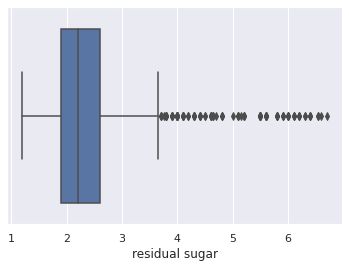

In [10]:
sns.boxplot(wine['residual sugar'])

Z-score is often used to identify outliers in a dataset. Normally data should lie within the z-score of +/- 3 range, so I applied this logic to eliminate the outliers, which left 1451 observations.

z-score通常会用来判定一个值是否偏离了均值成为异常。大部分数据应该都是不超过(+/-3)的范围，因此我取出z-score小于3的数据来排除异常值, 数据从1599排除后剩1451.

In [7]:
z = np.abs(stats.zscore(wine))
wine = wine[(z < 3).all(axis=1)]
wine.shape

(1451, 12)

In [ ]:
### relationship among variables 观察变量

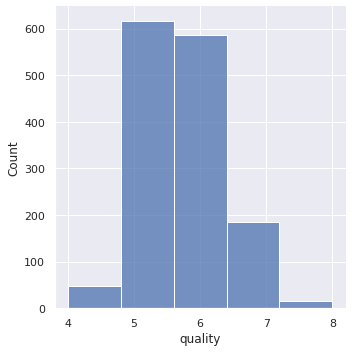

In [16]:
sns.displot(data=wine, x='quality', kind='hist', bins=5)

We can see that most of the wines here from the dataset are within 5 and 6, which we can label that 7 and beyond should be top of the quality, or an 'excellent' wine as our classification.

从‘quality’的分布来看，大部分的酒都在5和6分的区间。作为分类算法的项目，我们可以设7分或以上的酒为‘excellent’，优秀的品质。


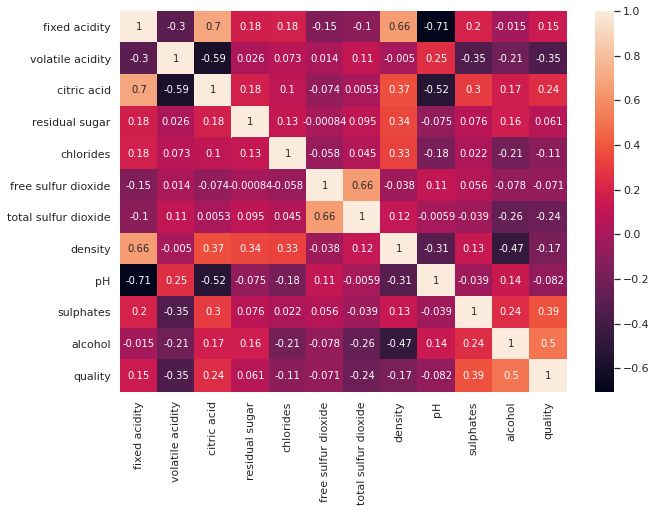

In [17]:
### Corelation 相关性
corr = wine.corr()
plt.subplots(figsize=(10,7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

Looking at the heatmap, we can identify some variables such as alcohol, volatile acidity, and sulphates with moderate correlation to 'quality', which are helpful to be featured in our classification model later.

从相关性的热图中可以发现，其中酒精含量，波动酸度和硫酸盐表现出对酒质量的影响力。之后我们可以把这些因素作为我们分类算法模型的因变量。

In [19]:
# Create Classification variable for the target 制定分类标签
wine['excellent'] = [1 if x >= 7 else 0 for x in wine['quality']]
# Separate feature variables and target variable
X = wine.drop(['quality','excellent'], axis = 1)
y = wine['excellent']

In [20]:
# Check the counts under each class 查询各标签的数据量
wine['excellent'].value_counts()

0    1250
1     201
Name: excellent, dtype: int64

## **Pre-modeling 模型的准备工作**

#### Standardizing Feature Variables 标准化变量

Standardizing the data will help equalize the range of the data by getting the distribution mean of 0 and standard deviation of 1.

标准化使其分布的平均值为 0，标准差为 1, 使变量的数据范围更小一些。


In [21]:
# normalize feature variables
from sklearn.preprocessing import StandardScaler
X_features = X
X = StandardScaler().fit_transform(X)

In [22]:
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

### **Modelling 测试模型**
#### Decision Trees 决策树
Decision trees are a popular supervised model for classification and regression that are often used in risk management and operation strategy. Decision trees are easy to build and to intepret but less accurate when it comes to prediction.

决策树是一种常用的监督学习的分类方法，常用于运筹学和风险管理当中。决策树相对计算量简单和容易解释，但容易过拟合。

In [24]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

tree_model= DecisionTreeClassifier(random_state=1)
tree_model.fit (X_train,y_train)
tree_pred= tree_model.predict(X_test)

print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       309
           1       0.55      0.50      0.52        54

    accuracy                           0.87       363
   macro avg       0.73      0.71      0.72       363
weighted avg       0.86      0.87      0.86       363



### Random Forest 随机森林

Random forest is an ensemble learning method that uses multiple decision trees and make a prediction based on the majority of what the trees predict.

随机森林在机器学习中是一个利用多个决策树对样本进行训练并预测的一个模型。

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
forest_pred = forest_model.predict(X_test)
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       309
           1       0.75      0.56      0.64        54

    accuracy                           0.91       363
   macro avg       0.84      0.76      0.79       363
weighted avg       0.90      0.91      0.90       363



Random Forest showed better performance in terms of recall and precision. One of the reason causing the less-accurate results for both models could be the imbalanced data, where a large sample size of data distributed in class 0.

这个模型从recall和 precision上都比决策树更高一些。这两个模型缺乏准确性的原因之一应该是数据的不平衡性（0的数据占多）。不过基于这两个模型，我们还是选择随机森林作为我们的模型。

## **Conclusion 总结**

In this project, I used EDA to identify 3 correlated variables to predict the quality of a wine, and built Decision Tree and Random Forest model to  predict the quality of a wine. Due to the imbalance of the classes, we still need to seek for better model even though the precision of Random Forest is higher. Perhaps I will do a part-2 of this project with other models to find the best model for future use.

在这个项目中，我对这份数据做了探索性分析找到3个与红酒质量高相关的因素，并搭建决策树和随机森林两个模型来预测红酒的质量。虽然随机森林的结果比决策树稍好，但鉴于该模型对‘excellent’酒预判的代表性和准确性偏低（可能由于本身数据在0和1分类中的不平衡），因此最后的结论是寻找更好的模型。或许之后会出一个part2来寻找一个更好的预测模型。

